In [1]:
from src import Data, myModel
import matplotlib.pyplot as plt
import numpy as np

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, batch_size=32, shuffle=True):
        'Initialization'
        self.X_IDs = sorted(glob.glob(path+"images/images/*.tif"))
        self.Y_IDs = sorted(glob.glob(path+"labels/images/*.tif"))
        if len(self.X_IDs) != len(self.Y_IDs):
            raise ValueError('imgs and labels are not matched')
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        X_IDs_temp = [self.X_IDs[k] for k in indexes]
        Y_IDs_temp = [self.Y_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(X_IDs_temp, Y_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, X_IDs_temp, Y_IDs_temp):
        'Generates data containing batch_size samples' 
        # X_out : (n_samples, *dim, n_channels)
        # Y_out : (n_samples, *dim, n_classes)
        # Initialization
        X_out = []
        Y_out = []
        for i in range(len(X_IDs_temp)):
            X_out.append(self.img_to_array(self.X_IDs[i]))
            Y_out.append(self.img_to_array(self.Y_IDs[i], dtype='int'))
        return np.asarray(X_out), np.asarray(Y_out)
    
    def img_to_array(self, input_file, dtype='float32'):
        """
        convert a raster tile into numpy array
        input:
            input_file: string, path a raster(.tif)
            normalizer: double, if input is labels with 0 or 1, it's 1.
                                if input is sentinal data (reflectance), then it's 10000.
            dtype: string, data type, default as 'float32'
        return:
            arr: numpy array, shape is [dim_y, dim_x, num_bands]
        """
        file = gdal.Open(input_file)
        bands = [np.array(file.GetRasterBand(i).ReadAsArray()).astype(dtype) for i in range(1, file.RasterCount + 1)]
        arr = np.stack(bands, axis=2)
        return arr

#### load X-Y samples from block1, and split into train and test sets

In [2]:
data = Data('./data/block1/')
min_list, max_list = data.get_MinMax('./data/block1/raw_data/workspace/sent_geo_clip.tif')
print('have {0} image tiles in totle'.format(len(data.X)))
X_trn0, Y_trn0 = data.get_XY(min_list, max_list, num=100, as_arr=True, random=False)
print('have {0} image tiles in totle'.format(len(data.X)))
# X_trn, X_tst, Y_trn, Y_tst = data.trn_tst_split(test_rate=0.1, random_seed=42)

have 4536 image tiles in totle
loading 0 - 99 image tiles
have 4436 image tiles in totle


In [3]:
X_trn1, Y_trn1 = data.get_XY(min_list, max_list, start=108, num=100, as_arr=True, random=False)
print('have {0} image tiles in totle'.format(len(data.X)))

loading 108 - 207 image tiles
have 4336 image tiles in totle


In [4]:
X_trn = np.concatenate([X_trn0, X_trn1], axis=0)
Y_trn = np.concatenate([Y_trn0, Y_trn1], axis=0)

#### visualize images and labels

Text(0.5,1,'lithological mappinp')

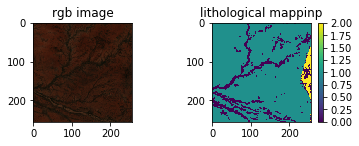

In [7]:
idx = 120
img = X_trn[idx,:,:,:]
lbl = Y_trn[idx,:,:,:]

img_rgb = img[:,:,:3][:,:,::-1]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=2))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [8]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(num_bands=23, n_ch_list=[64,64], use_tfboard=False)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=False)

# build callback for the details of train process
conv.build_callbackList()

building Conv2D ...
[64, 64]
[64]
compiling model ...


In [27]:
# load data from last checkpoint
# conv.load_checkpoint()
# size_block = 500
# for i in range(8):
#     X_trn, Y_trn = data.get_XY(min_list, max_list, start=i*size_block, num=size_block, as_arr=True)
#     # start to training
#     conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, batch_size=10, num_epochs=1, verbose=1)

In [18]:
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, batch_size=10, num_epochs=30, verbose=1)

Train on 160 samples, validate on 40 samples
Epoch 1/30
160/160 [==============================] - 359s 2s/step - loss: 1.2128 - acc: 0.5117 - val_loss: 1.6829 - val_acc: 0.3043

Epoch 00001: val_acc did not improve
Epoch 2/30
160/160 [==============================] - 328s 2s/step - loss: 1.1948 - acc: 0.5230 - val_loss: 1.7761 - val_acc: 0.3145

Epoch 00002: val_acc did not improve
Epoch 3/30
160/160 [==============================] - 335s 2s/step - loss: 1.1616 - acc: 0.5349 - val_loss: 1.8912 - val_acc: 0.2673

Epoch 00003: val_acc did not improve
Epoch 4/30
160/160 [==============================] - 324s 2s/step - loss: 1.2127 - acc: 0.5097 - val_loss: 1.7400 - val_acc: 0.4298


KeyboardInterrupt: 

#### predict on test data

In [10]:
# conv.save_weights('./Conv2D/weights-11-.hdf5')
# conv.load_weights('./Conv2D/weights-08-0.58.hdf5')

In [10]:
X_tst, Y_tst = data.get_XY(min_list, max_list, start=220, num=40, as_arr=True, random=False)
print('have {0} image tiles in totle'.format(len(data.X)))

loading 220 - 259 image tiles
have 4296 image tiles in totle


In [11]:
Y_preds = conv.predict(X_tst=X_tst)

40/40 [==============================] - 33s 820ms/step


#### visualize predicted Y

Text(0.5,1,'prediction')

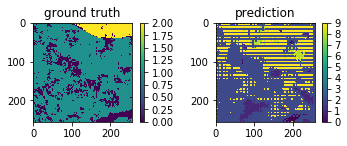

In [17]:
idx = 25
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(Y_tst[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [16]:
acc_list = []
for i in range(Y_tst.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(Y_tst[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.26898841857910155, std is 0.19582372201293222
max is 0.6697235107421875, min is 0.001922607421875


In [28]:
X_trn[19,:,:,0]

array([[4.2800002e-02, 4.1000001e-02, 4.2300001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.2199999e-02, 3.8100000e-02, 4.5899998e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [4.4500001e-02, 3.7400000e-02, 3.9999999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       ...,
       [4.4199999e-02, 4.6700001e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.9400000e-02, 4.6000000e-02, 4.0899999e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34],
       [3.6800001e-02, 4.2599998e-02, 4.6700001e-02, ..., 3.4028236e+34,
        3.4028236e+34, 3.4028236e+34]], dtype=float32)

In [41]:
tmp = data.img_to_array(data.X[92], min_list=min_list, max_list=max_list)

In [44]:
np.where(tmp>1)

(array([  0,   0,   0, ..., 255, 255, 255], dtype=int64),
 array([ 97,  97,  97, ..., 255, 255, 255], dtype=int64),
 array([ 0,  1,  2, ..., 20, 21, 22], dtype=int64))

In [45]:
tmp[0,97,0]

3.4028236e+34

In [46]:
from osgeo import gdal

In [59]:
file = gdal.Open(data.X[92])

In [66]:
aa = file.GetRasterBand(23)

In [52]:
path = './data/block1/sentinel_images/images/000000109.tif'

In [73]:
tmp[tmp>0.1] = 0

In [74]:
tmp

array([[[0.045     , 0.0779    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0445    , 0.075     , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0432    , 0.0745    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.0434    , 0.0773    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0443    , 0.0781    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        [0.0455    , 0.0744    , 0.        , ..., 0.03156779,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 